In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Dec 13 16:17:21 2022

@author: matte
"""

import random
import mattepy as mp
import mne
import saving as sv
import numpy as np
import pandas as pd
from os.path import join as pjoin
from itertools import product
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import colors
import os
import scipy
import pickle
import xgi
from xgi import dynamics
#import utils_avalanches as av
import warnings 
#import Utils_FC as fc
from lempel_ziv_complexity import lempel_ziv_complexity

warnings.simplefilter('ignore')

#path='/home/jeremy/anaconda3/matteo/'
path='C:/Users/matte/OneDrive/Documenti/matteo/'

## Here some functions

import numpy as np
import xarray as xr

import itertools

from frites.conn import conn_io
from frites.io import logger, check_attrs
from frites.utils import parallel_func
from frites.core import copnorm_nd


def ent_g(x):
    """Entropy of a tensor of shape (..., n_vars, n_trials)"""
    nvarx, ntrl = x.shape[-2], x.shape[-1]

    # covariance
    c = np.einsum('...ij, ...kj->...ik', x, x)
    c /= float(ntrl - 1.)
    chc = np.linalg.cholesky(c)

    # entropy in nats
    hx = np.log(np.einsum('...ii->...i', chc)).sum(-1) + 0.5 * nvarx * (
        np.log(2 * np.pi) + 1.0)
    return hx


def compute_oinfo(x, ind):
    """Compute the O-info.

    x.shape = (..., n_vars, n_trials)
    ind = indices for tensor-computations
    """
    nvars = x.shape[-2]
    o = (nvars - 2) * ent_g(x)
    o += (ent_g(x[..., np.newaxis, :]) - ent_g(x[..., ind, :])).sum(1)
    return o

def compute_tc(x):
    """Compute the O-info.

    x.shape = (..., n_vars, n_trials)
    ind = indices for tensor-computations
    """
    nvars = x.shape[-2]
    o = -ent_g(x)
    o += (ent_g(x[..., np.newaxis, :])).sum(1)
    return o

def combinations(n, k, roi, task_related=False):
    """Get combinations."""
    combs = np.array(list(itertools.combinations(np.arange(n), k)))

    # add behavior as a final columns
    if task_related:
        combs = np.c_[combs, np.full((combs.shape[0],), n)]

    # build brain region names
    roi_st = ['-'.join(r) for r in roi[combs].tolist()]

    return combs, roi_st

def simulate_kuramoto(H, k2, k3, omega=None, theta=None, timesteps=10000, dt=0.002):
    """Simulates the Kuramoto model on hypergraphs.
    This solves the Kuramoto model ODE on hypergraphs with edges of sizes 2 and 3
    using the Euler Method. It returns timeseries of the phases.
    Parameters
    ----------
    H : Hypergraph object
        The hypergraph on which you run the Kuramoto model
    k2 : float
        The coupling strength for links
    k3 : float
        The coupling strength for triangles
    omega : numpy array of real values
        The natural frequency of the nodes. If None (default), randomly drawn from a normal distribution
    theta : numpy array of real values
        The initial phase distribution of nodes. If None (default), drawn from a random uniform distribution
        on [0, 2pi[.
    timesteps : int greater than 1, default: 10000
        The number of timesteps for Euler Method.
    dt : float greater than 0, default: 0.002
        The size of timesteps for Euler Method.
    Returns
    -------
    theta_time: numpy array of floats
        Timeseries of phases from the Kuramoto model, of dimension (N, T)
    times: numpy array of floats
        Times corresponding to the simulate phases
    References
    ----------
    "Synchronization of phase oscillators on complex hypergraphs"
    by Sabina Adhikari, Juan G. Restrepo and Per Sebastian Skardal
    https://doi.org/10.48550/arXiv.2208.00909
    Examples
    --------
    >>> import numpy as np
    >>> import xgi
    >>> n = 50
    >>> H = xgi.random_hypergraph(n, [0.05, 0.001], seed=None)
    >>> omega = 2*np.ones(n)
    >>> theta = np.linspace(0, 2*np.pi, n)
    >>> theta_time, times = simulate_kuramoto(H, k2=2, k3=3, omega=omega, theta=theta)
    """
    H_int = xgi.convert_labels_to_integers(H, "label")

    links = H_int.edges.filterby("size", 2).members()
    triangles = H_int.edges.filterby("size", 3).members()
    n = H_int.num_nodes

    theta_time = np.zeros((n, timesteps))
    times = np.arange(timesteps) * dt

    if omega is None:
        omega = np.random.normal(0, 1, n)

    if theta is None:
        theta = np.random.random(n) * 2 * np.pi

    for t in range(timesteps):

        theta_time[:, t] = theta

        r1 = np.zeros(n, dtype=complex)
        r2 = np.zeros(n, dtype=complex)

        for i, j in links:

            r1[i] += np.exp(1j * theta[j])
            r1[j] += np.exp(1j * theta[i])

        for i, j, k in triangles:

            r2[i] += np.exp(2j * theta[j] - 1j * theta[k]) + np.exp(
                2j * theta[k] - 1j * theta[j]
            )
            r2[j] += np.exp(2j * theta[i] - 1j * theta[k]) + np.exp(
                2j * theta[k] - 1j * theta[i]
            )
            r2[k] += np.exp(2j * theta[i] - 1j * theta[j]) + np.exp(
                2j * theta[j] - 1j * theta[i]
            )

        d_theta = (
            omega
            + k2 * np.multiply(r1, np.exp(-1j * theta)).imag
            + k3 * np.multiply(r2, np.exp(-1j * theta)).imag
        )
        theta_new = theta + d_theta * dt
        theta = theta_new

    return theta_time, times

def conn_hoi(data, y=None, times=None, roi=None, minsize=3, maxsize=5,
             verbose=None):
    """Dynamic, possibly task-related, higher-order interactions.

    Parameters
    ----------
    data : array_like
        Electrophysiological data. Several input types are supported :

            * Standard NumPy arrays of shape (n_epochs, n_roi, n_times)
            * mne.Epochs
            * xarray.DataArray of shape (n_epochs, n_roi, n_times)

    y : array_like
        The feature of shape (n_trials,) for estimating task-related O-info.
    roi : array_like | None
        Array of region of interest name of shape (n_roi,)
    times : array_like | None
        Array of time points of shape (n_times,)
    minsize, maxsize : int | 3, 5
        Minimum and maximum size of the multiplets

    Returns
    -------
    oinfo : array_like
        The O-info array of shape (n_multiplets, n_times) where positive values
        reflect redundant dominated interactions and negative values stand for
        synergistic dominated interactions.
    """
    # ________________________________ INPUTS _________________________________
    # inputs conversion
    is_task_related = isinstance(y, (str, list, np.ndarray, tuple))
    kw_links = {'directed': False, 'net': False}
    data, cfg = conn_io(
        data, y=y, times=times, roi=roi, name='DynOinfo', verbose=verbose,
        kw_links=kw_links
    )

    # extract variables
    x, attrs = data.data, cfg['attrs']
    y, roi, times = data['y'].data, data['roi'].data, data['times'].data
    n_roi = len(roi)

    # get the maximum size of the multiplets investigated
    if not isinstance(maxsize, int):
        maxsize = n_roi
    maxsize = max(1, maxsize)
    assert maxsize > minsize

    logger.info(f"Compute the {'task-related ' * is_task_related} HOI "
                f"(min={minsize}; max={maxsize})")

    # ________________________________ O-INFO _________________________________
    logger.info("    Copnorm the data")

    # for task-related, add behavior along spatial dimension
    if is_task_related:
        y = np.tile(y.reshape(-1, 1, 1), (1, 1, len(times)))
        x = np.concatenate((x, y), axis=1)
        roi = np.r_[roi, ['beh']]

    # copnorm and demean the data
    x = copnorm_nd(x.copy(), axis=0)
    x = (x - x.mean(axis=0, keepdims=True))

    # make the data (n_times, n_roi, n_trials)
    x = x.transpose(2, 1, 0)

    oinfo, roi_o = [], []
    for msize in range(minsize, maxsize + 1):
        # ------------------------------ INDICES ------------------------------
        ish = msize if not is_task_related else msize + 1
        ind = np.zeros((ish, ish), dtype=int)
        vec = np.arange(ish)
        for shift in range(ish):
            ind[shift, :] = np.roll(vec, -shift)
        ind = ind[:, 1:]

        # ----------------------------- MULTIPLETS ----------------------------
        logger.info(f"    Multiplets of size {msize}")
        combs, _roi_o = combinations(
            n_roi, msize, roi, task_related=is_task_related)
        roi_o += _roi_o

        # ------------------------------- O-INFO ------------------------------
        for mult in combs:
            _oinfo = compute_oinfo(x[:, mult, :], ind)
            oinfo += [_oinfo]
    oinfo = np.stack(oinfo, 0)

    # _______________________________ OUTPUTS _________________________________
    attrs.update(dict(
        task_related=is_task_related, minsize=minsize, maxsize=maxsize
    ))
    oinfo = xr.DataArray(
        oinfo, dims=('roi', 'times'), coords=(roi_o, times), name="Oinfo",
        attrs=check_attrs(attrs)
    )

    return oinfo

def compute_kuramoto_order_parameter(theta_time):
    """This function calculates the order parameter for the Kuramoto model on hypergraphs,
    from time series, which is a measure of synchrony.
    Parameters
    ----------
    theta_time: numpy array of floats
        Timeseries of phases from the Kuramoto model, of dimension (N, T)
    Returns
    -------
    r_time : numpy array of floats
        Timeseries for Kuramoto model order parameter
    """

    z = np.mean(np.exp(1j * theta_time), axis=0)
    r_time = np.abs(z)

    return r_time



def conn_tc(data, y=None, times=None, roi=None, minsize=3, maxsize=5,
             verbose=None):
    """Dynamic, possibly task-related, higher-order interactions.

    Parameters
    ----------
    data : array_like
        Electrophysiological data. Several input types are supported :

            * Standard NumPy arrays of shape (n_epochs, n_roi, n_times)
            * mne.Epochs
            * xarray.DataArray of shape (n_epochs, n_roi, n_times)

    y : array_like
        The feature of shape (n_trials,) for estimating task-related O-info.
    roi : array_like | None
        Array of region of interest name of shape (n_roi,)
    times : array_like | None
        Array of time points of shape (n_times,)
    minsize, maxsize : int | 3, 5
        Minimum and maximum size of the multiplets

    Returns
    -------
    oinfo : array_like
        The O-info array of shape (n_multiplets, n_times) where positive values
        reflect redundant dominated interactions and negative values stand for
        synergistic dominated interactions.
    """
    # ________________________________ INPUTS _________________________________
    # inputs conversion
    is_task_related = isinstance(y, (str, list, np.ndarray, tuple))
    kw_links = {'directed': False, 'net': False}
    data, cfg = conn_io(
        data, y=y, times=times, roi=roi, name='DynOinfo', verbose=verbose,
        kw_links=kw_links
    )

    # extract variables
    x, attrs = data.data, cfg['attrs']
    y, roi, times = data['y'].data, data['roi'].data, data['times'].data
    n_roi = len(roi)

    # get the maximum size of the multiplets investigated
    if not isinstance(maxsize, int):
        maxsize = n_roi
    maxsize = max(1, maxsize)
    assert maxsize > minsize

    logger.info(f"Compute the {'task-related ' * is_task_related} HOI "
                f"(min={minsize}; max={maxsize})")

    # ________________________________ O-INFO _________________________________
    logger.info("    Copnorm the data")

    # for task-related, add behavior along spatial dimension
    if is_task_related:
        y = np.tile(y.reshape(-1, 1, 1), (1, 1, len(times)))
        x = np.concatenate((x, y), axis=1)
        roi = np.r_[roi, ['beh']]

    # copnorm and demean the data
    x = copnorm_nd(x.copy(), axis=0)
    x = (x - x.mean(axis=0, keepdims=True))

    # make the data (n_times, n_roi, n_trials)
    x = x.transpose(2, 1, 0)

    oinfo, roi_o = [], []
    for msize in range(minsize, maxsize + 1):
        # ------------------------------ INDICES ------------------------------
        ish = msize if not is_task_related else msize + 1
        ind = np.zeros((ish, ish), dtype=int)
        vec = np.arange(ish)
        for shift in range(ish):
            ind[shift, :] = np.roll(vec, -shift)
        ind = ind[:, 1:]

        # ----------------------------- MULTIPLETS ----------------------------
        logger.info(f"    Multiplets of size {msize}")
        combs, _roi_o = combinations(
            n_roi, msize, roi, task_related=is_task_related)
        roi_o += _roi_o

        # ------------------------------- O-INFO ------------------------------
        for mult in combs:
            _oinfo = compute_tc(x[:, mult, :])
            oinfo += [_oinfo]
    oinfo = np.stack(oinfo, 0)

    # _______________________________ OUTPUTS _________________________________
    attrs.update(dict(
        task_related=is_task_related, minsize=minsize, maxsize=maxsize
    ))
    oinfo = xr.DataArray(
        oinfo, dims=('roi', 'times'), coords=(roi_o, times), name="Oinfo",
        attrs=check_attrs(attrs)
    )

    return oinfo


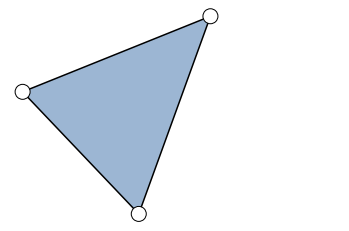

doing simulation number: 0
doing simulation number: 1
doing simulation number: 2
doing simulation number: 3
doing simulation number: 4
doing simulation number: 5
doing simulation number: 6
doing simulation number: 7
doing simulation number: 8
doing simulation number: 9
doing simulation number: 10
doing simulation number: 11
doing simulation number: 12
doing simulation number: 13
doing simulation number: 14
doing simulation number: 15
doing simulation number: 16
doing simulation number: 17
doing simulation number: 18
doing simulation number: 19
doing simulation number: 20
doing simulation number: 21
doing simulation number: 22
doing simulation number: 23
doing simulation number: 24
doing simulation number: 25
doing simulation number: 26
doing simulation number: 27
doing simulation number: 28
doing simulation number: 29


In [4]:



#parameter
hyperedge_list4=[[1,2],[1,2,3],[0,2,3],[2,3],[1,3],[0,3],[0,2]]
hyperedge_list3=[[0,1,2],[1,2],[0,1],[0,2]]

ind3=np.array([[1,2],[0,1],[2,0]])
ind4=np.array([[1,2,3],[0,1,2],[3,0,1],[2,3,0]])

H= xgi.classes.hypergraph.Hypergraph(hyperedge_list3)
xgi.draw(H)
plt.show()
plt.close()


n_it=30
aax=np.arange(0.1,2.5,.2)

oinfo_matrix=np.zeros((n_it, len(aax), len(aax)))
order_parameter_matrix=np.zeros((n_it, len(aax), len(aax)))

for n in range(n_it):
    print("doing simulation number:", n)
    for i, k2 in enumerate(aax):
        
        for j, k3 in enumerate(aax):
    
    
            x_theta, times=simulate_kuramoto(H, k2, k3, omega=None, theta=None, timesteps=5000, dt=0.01)
    
            sv.saving(x_theta, path + "theta_k2_k3_n"+str(k2)+str(k3)+str(n))